In [33]:
import torch
import numpy as np
import torchvision.transforms as transforms
import os
from torchsummary import summary


from torch.utils.data import Dataset
import cv2 as cv
import matplotlib.pyplot as plt


import cv2
from os import listdir
import json
import random as rand
import pandas as pd
import matplotlib.colors as mcolors

import shutil


### SUNRGBD DATA

In [4]:
class FrameData:
	def __init__(self, imgRGB,annotation2D,labels2D):
		self.imgRGB = imgRGB
		self.annotation2D = annotation2D
		self.labels2D = labels2D
		
def readFrame( framePath, bfx ):
	#read RGB information to numpy array	
	rgbPath = framePath + "/image/" 
	rgbPath += listdir(rgbPath)[0]
	imgRGB = cv2.imread(rgbPath)
	
	#read depth information to numpy array
	if not(bfx):
		depthPath = framePath + "/depth/" 
	else:
		depthPath = framePath + "/depth_bfx/" 
	depthPath += listdir(depthPath)[0]
	
	#read 2D annotations to a list o numpy arrays where each index is related with one object polygon and a list where the index links the object polygon to the object label.
	annotation2D = framePath + "/annotation2Dfinal/index.json"
	
	with open(annotation2D) as data_file:    
		data = json.load(data_file)
			
	numberOfAnot = len(data["frames"][0]["polygon"])
	
	annotation2D = []
	labels2D = []
	for i in range(0,numberOfAnot):
		x = data["frames"][0]["polygon"][i]["x"]
		y = data["frames"][0]["polygon"][i]["y"]

		idxObj = data["frames"][0]["polygon"][i]["object"]
		pts2 = np.array([x,y], np.int32)
		pts2 = np.transpose(pts2)
		annotation2D.append(pts2)
		try:
			labels2D.append(data['objects'][idxObj]["name"])
		except:
			labels2D.append("Error")#encode this as error (later mapped to other)
		
	frameData = FrameData(imgRGB,annotation2D,labels2D)

	return frameData

In [20]:
#import the seg list and make a dict to map values
seglist = pd.read_csv("seglistall.csv") # thank you : https://github.com/crmauceri/SUNRGBD_COCO/blob/main/seglistall.csv
seglist["seg37list label"].fillna("other",inplace = True)
to_37 = seglist.set_index('original_labels')['seg37list label'].to_dict()
names = list(set(to_37.values()))
if "other" not in names:
    names.append("other")

colors = np.linspace(0, (len(names)-1)/2, len(names))
colors = {names[i].lower():colors[i] for i in range(len(names))}


In [21]:
def process_folder(directory_path): 
## modified the code from  --> https://github.com/luiszeni/SUNRGBDtoolbox_python/tree/master
    not_in = dict()
    image_num = 0
    for filename in os.listdir(directory_path)[1:]:
        try:
            file_path = os.path.join(directory_path, filename)
            frameData = readFrame( file_path,True )
            imgRGBWithAnnotations = np.full((frameData.imgRGB.shape[0], frameData.imgRGB.shape[1],1 ), colors["other"], dtype=np.uint8)
            for i in range(0, len(frameData.annotation2D)):
                label = frameData.labels2D[i].lower()
                try:
                    color = colors[to_37[label]]
                except:
                    color = colors["other"]
                    if label in not_in.keys():
                        not_in[label] += 1
                    else:
                        not_in[label] = 1
                annot= np.atleast_2d(frameData.annotation2D[i])

                cv2.fillPoly(imgRGBWithAnnotations, [annot], color)

            np.save(f"indoor_data/image/{image_num}.npy",np.asarray(frameData.imgRGB))
            np.save(f"indoor_data/label/{image_num}.npy",np.asarray(imgRGBWithAnnotations))
            image_num += 1
        except:
            print("Error:",os.path.join(directory_path, filename))

    return sorted(not_in.items(), key=lambda item: item[1], reverse=True)
            

In [22]:
directory = "SUNRGBD/SUNRGBD/kv2/kinect2data"

#process the folder in this directory and return the dictionary of labels that were ignored
not_in = process_folder(directory)
#prints for each image that can't be processed

Error: SUNRGBD/SUNRGBD/kv2/kinect2data\000424_2014-06-08_17-05-00_260595134347_rgbf000115-resize
Error: SUNRGBD/SUNRGBD/kv2/kinect2data\000467_2014-06-09_19-35-24_260595134347_rgbf000188-resize
Error: SUNRGBD/SUNRGBD/kv2/kinect2data\000504_2014-06-08_23-03-02_260595134347_rgbf000064-resize
Error: SUNRGBD/SUNRGBD/kv2/kinect2data\000631_2014-06-08_16-30-36_260595134347_rgbf000088-resize
Error: SUNRGBD/SUNRGBD/kv2/kinect2data\000667_2014-06-09_21-06-12_260595134347_rgbf000145-resize
Error: SUNRGBD/SUNRGBD/kv2/kinect2data\000668_2014-06-09_21-07-12_260595134347_rgbf000161-resize
Error: SUNRGBD/SUNRGBD/kv2/kinect2data\001177_2014-06-17_15-46-38_260595134347_rgbf000056-resize
Error: SUNRGBD/SUNRGBD/kv2/kinect2data\002295_2014-06-28_19-00-10_260595134347_rgbf000138-resize
Error: SUNRGBD/SUNRGBD/kv2/kinect2data\002922_2014-06-26_15-43-16_094959634447_rgbf000089-resize
Error: SUNRGBD/SUNRGBD/kv2/kinect2data\003054_2014-06-15_13-54-54_094959634447_rgbf000113-resize
Error: SUNRGBD/SUNRGBD/kv2/kin

In [23]:
not_in

[('sign', 841),
 ('pricetag', 481),
 ('keyboard', 423),
 ('tag', 373),
 ('pillar', 302),
 ('outlet', 289),
 ('plant', 287),
 ('mouse', 287),
 ('trashcan', 284),
 ('cup', 279),
 ('bottle', 251),
 ('board', 208),
 ('glass', 172),
 ('handle', 172),
 ('blanket', 163),
 ('vent', 154),
 ('rack', 142),
 ('vase', 138),
 ('column', 138),
 ('lightswitch', 137),
 ('printer', 133),
 ('plate', 133),
 ('basket', 131),
 ('pipe', 124),
 ('bowl', 120),
 ('price', 112),
 ('cord', 111),
 ('error', 101),
 ('clock', 100),
 ('switch', 97),
 ('laptop', 94),
 ('tile', 94),
 ('chair2', 92),
 ('stand', 92),
 ('tablelamp', 88),
 ('ottoman', 87),
 ('electricaloutlet', 87),
 ('art', 84),
 ('pot', 84),
 ('cabinetdoor', 84),
 ('tableleg', 84),
 ('doorhandle', 83),
 ('wire', 82),
 ('faucet', 82),
 ('firealarm', 79),
 ('waterbottle', 79),
 ('microwave', 79),
 ('screen', 77),
 ('doorframe', 77),
 ('endtable', 76),
 ('chairleg', 76),
 ('coffeetable', 75),
 ('chair3', 74),
 ('chalkboard', 73),
 ('chair1', 73),
 ('podium'

In [8]:
#code used to fill in common mislabeled items
# for i in not_in:
#     if i[1]>100:

#         print(None,",",i[0],",",None,",","FILLHERE",",[],",i[1])

### Train Test Val Split

In [36]:

# find filenames directory
filenames = os.listdir("indoor_data/image/")
# for numbers 0  to numfiles-1 assign 300 to val randomly and 300 to test randomly
val_test = rand.sample(filenames,800)
test = rand.sample(val_test,400)
# for each file if in test move to test
tr = 0
va = 0
te = 0
for file in filenames:
    if file in test:
        destination_dir = "test" 
    elif file in val_test:
        destination_dir = "val"
    else:
        destination_dir = "train"
    shutil.move(f"indoor_data/image/{file}", f"indoor_data/{destination_dir}/image")
    shutil.move(f"indoor_data/label/{file}", f"indoor_data/{destination_dir}/label")

### Testing out the data

In [9]:
TRAIN_IMG_PATH = 'indoor_data/image'
TRAIN_LABEL_PATH = 'indoor_data/label'
# VAL_IMG_PATH = 'data/val/image'
# VAL_LABEL_PATH = 'data/val/label'
BATCHSIZE = 32
IMAGESIZE = 128

In [10]:
class IndoorDataset(Dataset):
    def __init__(self, transforms= None, train= True):
        self.train = train
        self.images_path = TRAIN_IMG_PATH
        self.labels_path = TRAIN_LABEL_PATH
        if not train:
            self.images_path = VAL_IMG_PATH
            self.labels_path = VAL_LABEL_PATH
            
        self.len = len(os.listdir(self.images_path))
        
    def __getitem__(self, index):
        #load sample {img,,label}
        naming_label = int(os.listdir(self.images_path)[index].split('.')[0])
        image = np.asarray(np.load(os.path.join(self.images_path, f'{os.listdir(self.images_path)[index]}')), 
                                            dtype= np.float32)
        image = cv.resize(image, (IMAGESIZE, IMAGESIZE))
        image = torch.from_numpy(image)
        image = image / 255
        image = image.permute(2, 0, 1)
        
        # only cars labels == 13
        label = np.load(os.path.join(self.labels_path, f'{naming_label}.npy'))
        label = cv.resize(label, (IMAGESIZE, IMAGESIZE))
        label = torch.from_numpy(label)
        label = torch.Tensor(label)
        label = label.reshape(1, IMAGESIZE, IMAGESIZE)
        return image, label
    
    def __len__(self):
        return self.len

In [11]:
training_set_indoor = IndoorDataset(train=True)
training_loader_indoor = torch.utils.data.DataLoader(training_set_indoor, batch_size=BATCHSIZE, shuffle=True)


In [123]:
#labels are RGB, need to change format

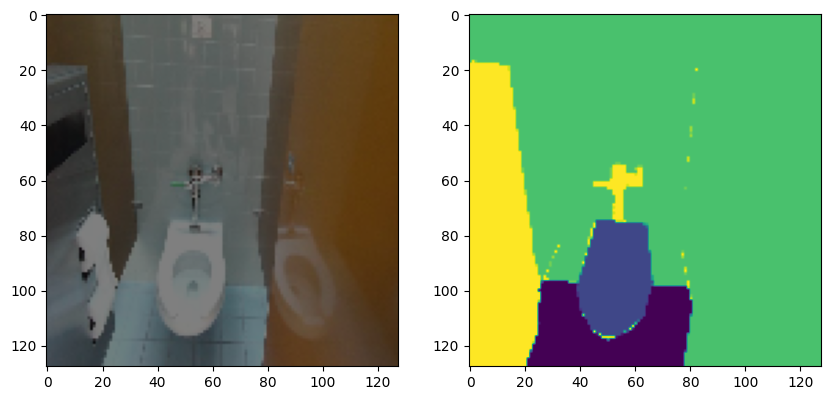

In [19]:
import matplotlib.pyplot as plt
def show_img_and_mask(img, label, epoch = None):
    if epoch != None:
        fig = plt.figure(figsize=(10, 7))
        fig.add_subplot(1, 2, 1)
        img = img.permute(1,2,0)
        plt.imshow(img * IMAGESIZE)
        fig.add_subplot(1, 2, 2)
        plt.imshow(label.permute(1,2,0))
        plt.savefig('pic/epoch_'+str(epoch)+'.png')
    else:
        fig = plt.figure(figsize=(10, 7))
        fig.add_subplot(1, 2, 1)
        img = img.permute(1,2,0)
        plt.imshow(img * IMAGESIZE)
        fig.add_subplot(1, 2, 2)
        plt.imshow(label.permute(1,2,0))
        
    return
for i, data in enumerate(training_loader_indoor):
    inputs,labels = data
    image =  3
    ulab = np.unique(labels[image].numpy())
    show_img_and_mask(inputs[image]/255,labels[image])
    break